## STAT8017 Project: Exploratory Data Analysis and Prediction on TIC COIL200 Dataset

In [269]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

from sklearn.cluster import KMeans

In [59]:
tic_data = pd.read_csv('ticdata2000.txt', sep='\t', header=None)
tic_data

,0,1,2,3,4,5,6,7,8,9,...,76,77,78,79,80,81,82,83,84,85
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,1
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# update the column headers to start from 1
tic_data.columns = [i for i in range(1, tic_data.shape[1] + 1)]
tic_data

,1,2,3,4,5,6,7,8,9,10,...,77,78,79,80,81,82,83,84,85,86
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,1
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


We observe that the dataset columns are integers. To map them to the correct names, we will load the file `dictionary.txt` and create a dataframe that maps integers to column names along with their descriptions. We will then use this mapping to rename the columns in the `tic_data` dataframe.

In [61]:
def get_mapping() -> tuple:
  """
  This function reads the dictionary file and returns the following mapping:
  - column_mapping_dict: a dictionary mapping the column index to the column name
  - l0_levels_dict: a dictionary mapping the level 0 index to the level 0 name
  - l1_levels_dict: a dictionary mapping the level 1 index to the level 1 name
  - l2_levels_dict: a dictionary mapping the level 2 index to the level 2 name
  - l3_levels_dict: a dictionary mapping the level 3 index to the level 3 name
  - l4_levels_dict: a dictionary mapping the level 4 index to the level 4 name
  """

  column_mapping_dict = {}
  with open('dictionary.txt', 'r', encoding='latin-1') as f:
    lines = f.readlines()[1:]
    
    lines = [line.strip() for line in lines]
    # remove empty lines
    lines = [line for line in lines if line]
    
    # remove the first line now which is the column names
    lines = lines[1:]
    
    # the next 86 lines are where column names are
    column_names = lines[:86]
    
    for line in column_names:
      # split the line by space
      line = line.split(sep=' ')
      
      # first element is the index
      # second element is the column name
      column_mapping_dict[int(line[0])] = line[1]
      
    # from the 87th line onwards, the lines contain mapping of levels to values
    
    # L0 is from line 88 to 128
    l0_levels = lines[88:128]
    l0_levels = [level.split(' ', maxsplit=1) for level in l0_levels]
    l0_levels_dict = {int(level[0]): level[1] for level in l0_levels }
    
    # L1 is from line 130 to 136
    l1_levels = lines[130:136]
    l1_levels = [level.split(' ', maxsplit=1) for level in l1_levels]
    l1_levels_dict = {int(level[0]): level[1] for level in l1_levels }
    
    # L2 is from line 137 to 147
    l2_levels = lines[137:147]
    l2_levels = [level.split(' ', maxsplit=1) for level in l2_levels]
    l2_levels_dict = {int(level[0]): level[1] for level in l2_levels }
    
    # L3 is from line 149 to 158
    l3_levels = lines[149:158]
    l3_levels = [level.split(' ', maxsplit=1) for level in l3_levels]
    l3_levels_dict = {int(level[0]): level[1] for level in l3_levels }
    
    # lastly, L4 is from line 159
    l4_levels = lines[159:]
    
    # L4 might have special character \x96
    # replace it with -
    l4_levels = [level.replace('\x96', '-') for level in l4_levels]
    
    l4_levels = [level.split(' ', maxsplit=1) for level in l4_levels]
    l4_levels_dict = {int(level[0]): level[1] for level in l4_levels }
    
  return column_mapping_dict, l0_levels_dict, l1_levels_dict, l2_levels_dict, l3_levels_dict, l4_levels_dict

In [62]:
# get the mapping
column_mapping_dict, l0_levels_dict, l1_levels_dict, l2_levels_dict, l3_levels_dict, l4_levels_dict = get_mapping()

In [64]:
# print the mapping
print("Column Mapping Dictionary:")
for key, value in column_mapping_dict.items():
  print(f"{key}: {value}")

Column Mapping Dictionary:
1: MOSTYPE
2: MAANTHUI
3: MGEMOMV
4: MGEMLEEF
5: MOSHOOFD
6: MGODRK
7: MGODPR
8: MGODOV
9: MGODGE
10: MRELGE
11: MRELSA
12: MRELOV
13: MFALLEEN
14: MFGEKIND
15: MFWEKIND
16: MOPLHOOG
17: MOPLMIDD
18: MOPLLAAG
19: MBERHOOG
20: MBERZELF
21: MBERBOER
22: MBERMIDD
23: MBERARBG
24: MBERARBO
25: MSKA
26: MSKB1
27: MSKB2
28: MSKC
29: MSKD
30: MHHUUR
31: MHKOOP
32: MAUT1
33: MAUT2
34: MAUT0
35: MZFONDS
36: MZPART
37: MINKM30
38: MINK3045
39: MINK4575
40: MINK7512
41: MINK123M
42: MINKGEM
43: MKOOPKLA
44: PWAPART
45: PWABEDR
46: PWALAND
47: PPERSAUT
48: PBESAUT
49: PMOTSCO
50: PVRAAUT
51: PAANHANG
52: PTRACTOR
53: PWERKT
54: PBROM
55: PLEVEN
56: PPERSONG
57: PGEZONG
58: PWAOREG
59: PBRAND
60: PZEILPL
61: PPLEZIER
62: PFIETS
63: PINBOED
64: PBYSTAND
65: AWAPART
66: AWABEDR
67: AWALAND
68: APERSAUT
69: ABESAUT
70: AMOTSCO
71: AVRAAUT
72: AAANHANG
73: ATRACTOR
74: AWERKT
75: ABROM
76: ALEVEN
77: APERSONG
78: AGEZONG
79: AWAOREG
80: ABRAND
81: AZEILPL
82: APLEZIER
83: AFI

In [65]:
# print the L0 levels
print("L0 Levels Dictionary:")
for key, value in l0_levels_dict.items():
  print(f"{key}: {value}")

L0 Levels Dictionary:
1: High Income, expensive child
2: Very Important Provincials
3: High status seniors
4: Affluent senior apartments
5: Mixed seniors
6: Career and childcare
7: Dinki's (double income no kids)
8: Middle class families
9: Modern, complete families
10: Stable family
11: Family starters
12: Affluent young families
13: Young all american family
14: Junior cosmopolitan
15: Senior cosmopolitans
16: Students in apartments
17: Fresh masters in the city
18: Single youth
19: Suburban youth
20: Etnically diverse
21: Young urban have-nots
22: Mixed apartment dwellers
23: Young and rising
24: Young, low educated
25: Young seniors in the city
26: Own home elderly
27: Seniors in apartments
28: Residential elderly
29: Porchless seniors: no front yard
30: Religious elderly singles
31: Low income catholics
32: Mixed seniors
33: Lower class large families
34: Large family, employed child
35: Village families
36: Couples with teens 'Married with children'
37: Mixed small town dwellers


In [66]:
# print the L1 levels
print("L1 Levels Dictionary:")
for key, value in l1_levels_dict.items():
  print(f"{key}: {value}")

L1 Levels Dictionary:
1: 20-30 years
2: 30-40 years
3: 40-50 years
4: 50-60 years
5: 60-70 years
6: 70-80 years


In [67]:
# print the L2 levels
print("L2 Levels Dictionary:")
for key, value in l2_levels_dict.items():
  print(f"{key}: {value}")

L2 Levels Dictionary:
1: Successful hedonists
2: Driven Growers
3: Average Family
4: Career Loners
5: Living well
6: Cruising Seniors
7: Retired and Religeous
8: Family with grown ups
9: Conservative families
10: Farmers


In [68]:
# print the L3 levels
print("L3 Levels Dictionary:")
for key, value in l3_levels_dict.items():
  print(f"{key}: {value}")

L3 Levels Dictionary:
1: 1 - 10%
2: 11 - 23%
3: 24 - 36%
4: 37 - 49%
5: 50 - 62%
6: 63 - 75%
7: 76 - 88%
8: 89 - 99%
9: 100%


In [69]:
# print the L4 levels
print("L4 Levels Dictionary:")
for key, value in l4_levels_dict.items():
  print(f"{key}: {value}")

L4 Levels Dictionary:
0: f 0
1: f 1 - 49
2: f 50 - 99
3: f 100 - 199
4: f 200 - 499
5: f 500 - 999
6: f 1000 - 4999
7: f 5000 - 9999
8: f 10.000 - 19.999
9: f 20.000 - ?


In [63]:
# we can now rename the columns in the tic_data dataframe
tic_data = tic_data.rename(columns=column_mapping_dict)
tic_data

,MOSTYPE,MAANTHUI,MGEMOMV,MGEMLEEF,MOSHOOFD,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,...,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND,CARAVAN
0,33,1,3,2,8,0,5,1,3,7,...,0,0,0,1,0,0,0,0,0,0
1,37,1,2,2,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
2,37,1,2,2,8,0,4,2,4,3,...,0,0,0,1,0,0,0,0,0,0
3,9,1,3,3,3,2,3,2,4,5,...,0,0,0,1,0,0,0,0,0,0
4,40,1,4,2,10,1,4,1,4,7,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,36,1,1,2,8,0,6,1,2,1,...,0,0,0,1,0,0,0,0,0,0
5818,35,1,4,4,8,1,4,1,4,6,...,0,0,0,1,0,0,0,0,0,0
5819,33,1,3,4,8,0,6,0,3,5,...,0,0,0,1,0,0,0,0,0,1
5820,34,1,3,2,8,0,7,0,2,7,...,0,0,0,0,0,0,0,0,0,0


### Exploratory Data Analysis

With the dataset loaded and the columns rennamed, we can now perform exploratory data analysis (EDA) to understand the data better. EDA will help us identify patterns, trends, and anomalies in the dataset. We will use various visualization techniques to explore the data.

In [71]:
# lets observe if there are any missing values in the data
missing_values = tic_data.isnull().sum()
missing_values = missing_values[missing_values > 0]

missing_values

Series([], dtype: int64)

The dataset looks to be complete and there are no missing values.

In [72]:
# The last column `CARAVAN` is the target variable
# the rest are the features. lets seperate them
target = tic_data['CARAVAN']
features = tic_data.drop(columns=['CARAVAN'])

# lets check the shape of the features and target
features.shape, target.shape

((5822, 85), (5822,))

The target variable `CARAVAN` indicates whether a customer has taken out a caravan insurance policy. 

The rest 85 columns are the features that we will use to predict the target variable.

#### Target Variable Analysis

We will start by analyzing the target variable `CARAVAN`. 

- 0 indicates that the customer has not taken out a caravan insurance policy.
- 1 indicates that the customer has taken out a caravan insurance policy.
 
We will check the distribution of the target variable to see how many customers have taken out a caravan insurance policy and how many have not. This will help us understand the class imbalance in the dataset.

In [73]:
print("Targer Variable Distribution:")
target.value_counts()

Targer Variable Distribution:


CARAVAN
0    5474
1     348
Name: count, dtype: int64

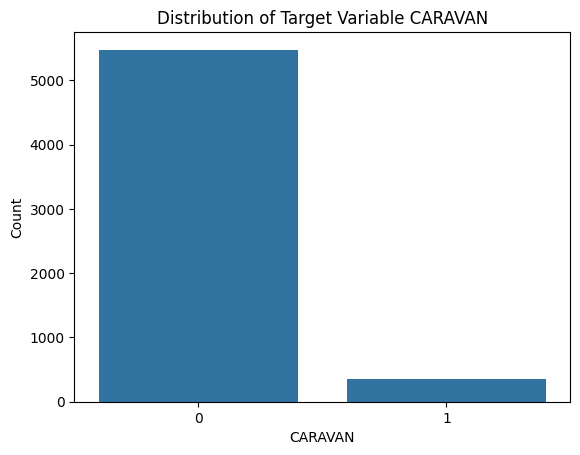

In [74]:
# plot the target variable distribution
sns.countplot(x=target)
plt.title("Distribution of Target Variable CARAVAN")
plt.xlabel("CARAVAN")
plt.ylabel("Count")
plt.show()

We see that most of the customers have not taken out a caravan insurance policy. This indicates that the dataset is imbalanced, which may affect the performance of our predictive model. **We will need to take this into account when building our model.**

#### Feature Analysis

Since the dataset has 85 features, we will not be able to analyze all of them in detail. Instead, we will focus on analyzing features in the following categories:

- **Socio-demographic features**: These features describe the demographic and socioeconomic characteristics of customers. They are primarily derived from zip codes. These are from columns 1 to 43
- **Product Ownership Features**: These features describe the ownership and contributions to various insurance products. These are from columns 44 to 85

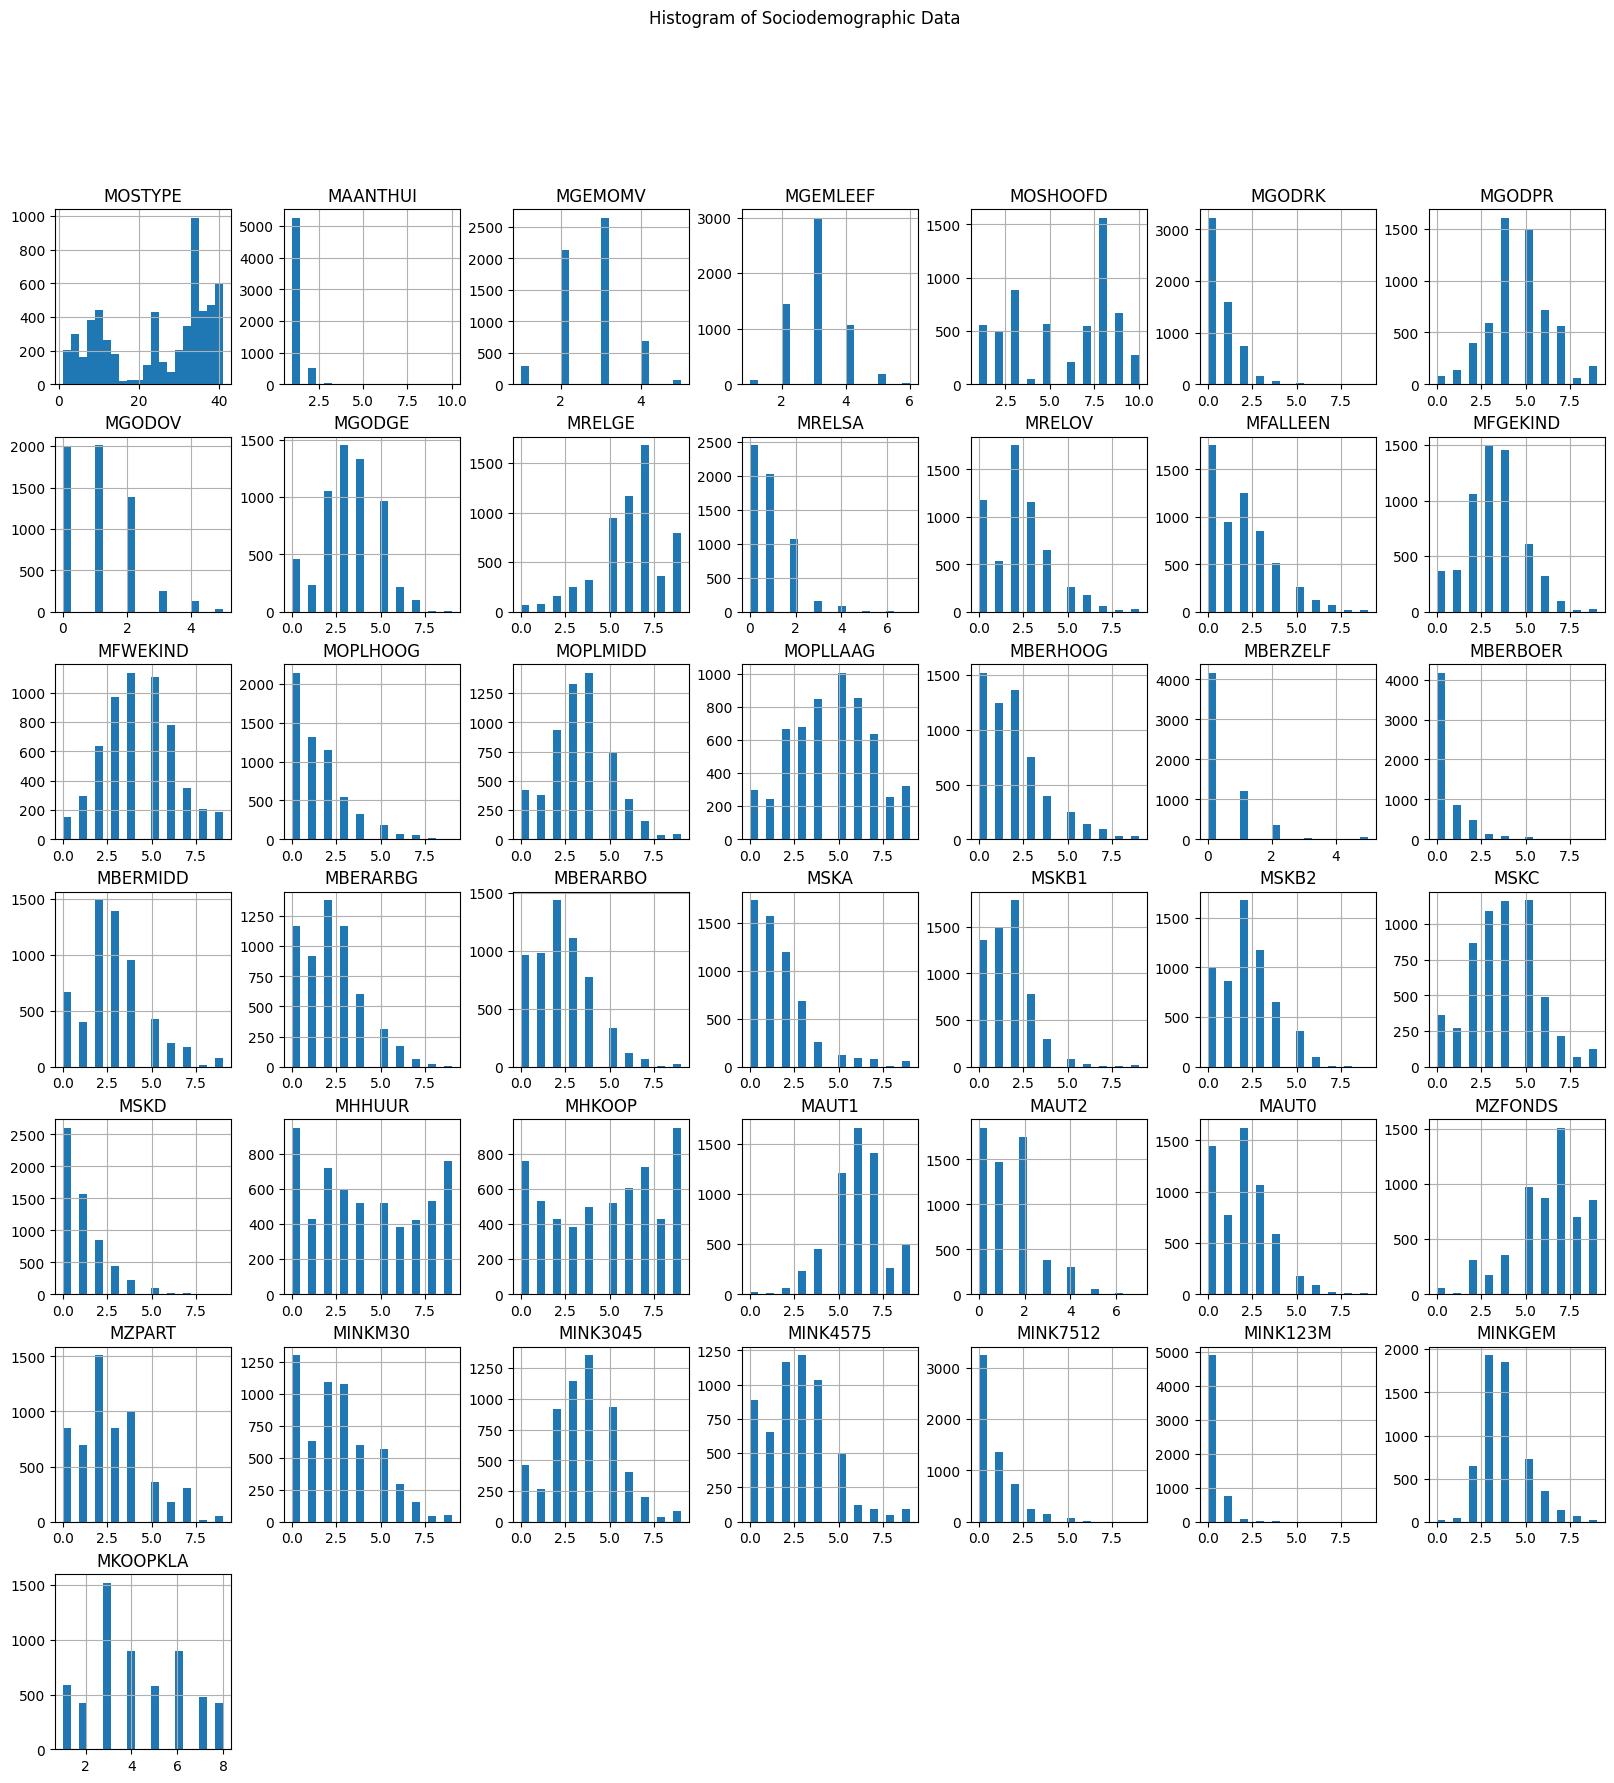

In [80]:
# sociodemographic data
sociodemographic_data = features.iloc[:, :43]

# plot the histogram of the sociodemographic data
sociodemographic_data.hist(figsize=(20, 20), bins=20)
plt.suptitle("Histogram of Sociodemographic Data")
plt.show()

Here are some of the key observations from Socio-demographic features:

- The dataset is dominated by a few customer subtypes and main types, indicating a focus on specific demographic groups.

- Most customers live in areas with fewer houses (1–3 houses) and have households with 2–4 members. Childless households are more common than those with children.

- Middle-aged individuals (30–50 years) are highly represented in the dataset.

- Roman Catholics dominate, but a significant proportion of areas are secular (no religion).

- Married or cohabiting individuals are more common, while singles and other relationships are less frequent.

- The population has moderate educational attainment, with medium-level education being the most common.

- Middle management and skilled laborers are prevalent, while entrepreneurs and farmers are less common. Lower social classes dominate, with higher social classes being less frequent.

- Renting is more common than homeownership. 

- Most customers own 1 car, while having no car or 2 cars is less frequent.

- Lower to middle-income groups dominate, with higher-income groups being less frequent.

- Most customers rely on public health services (National Health Service) rather than private insurance.

- Economic disparities are evident, with certain purchasing power classes being more common.

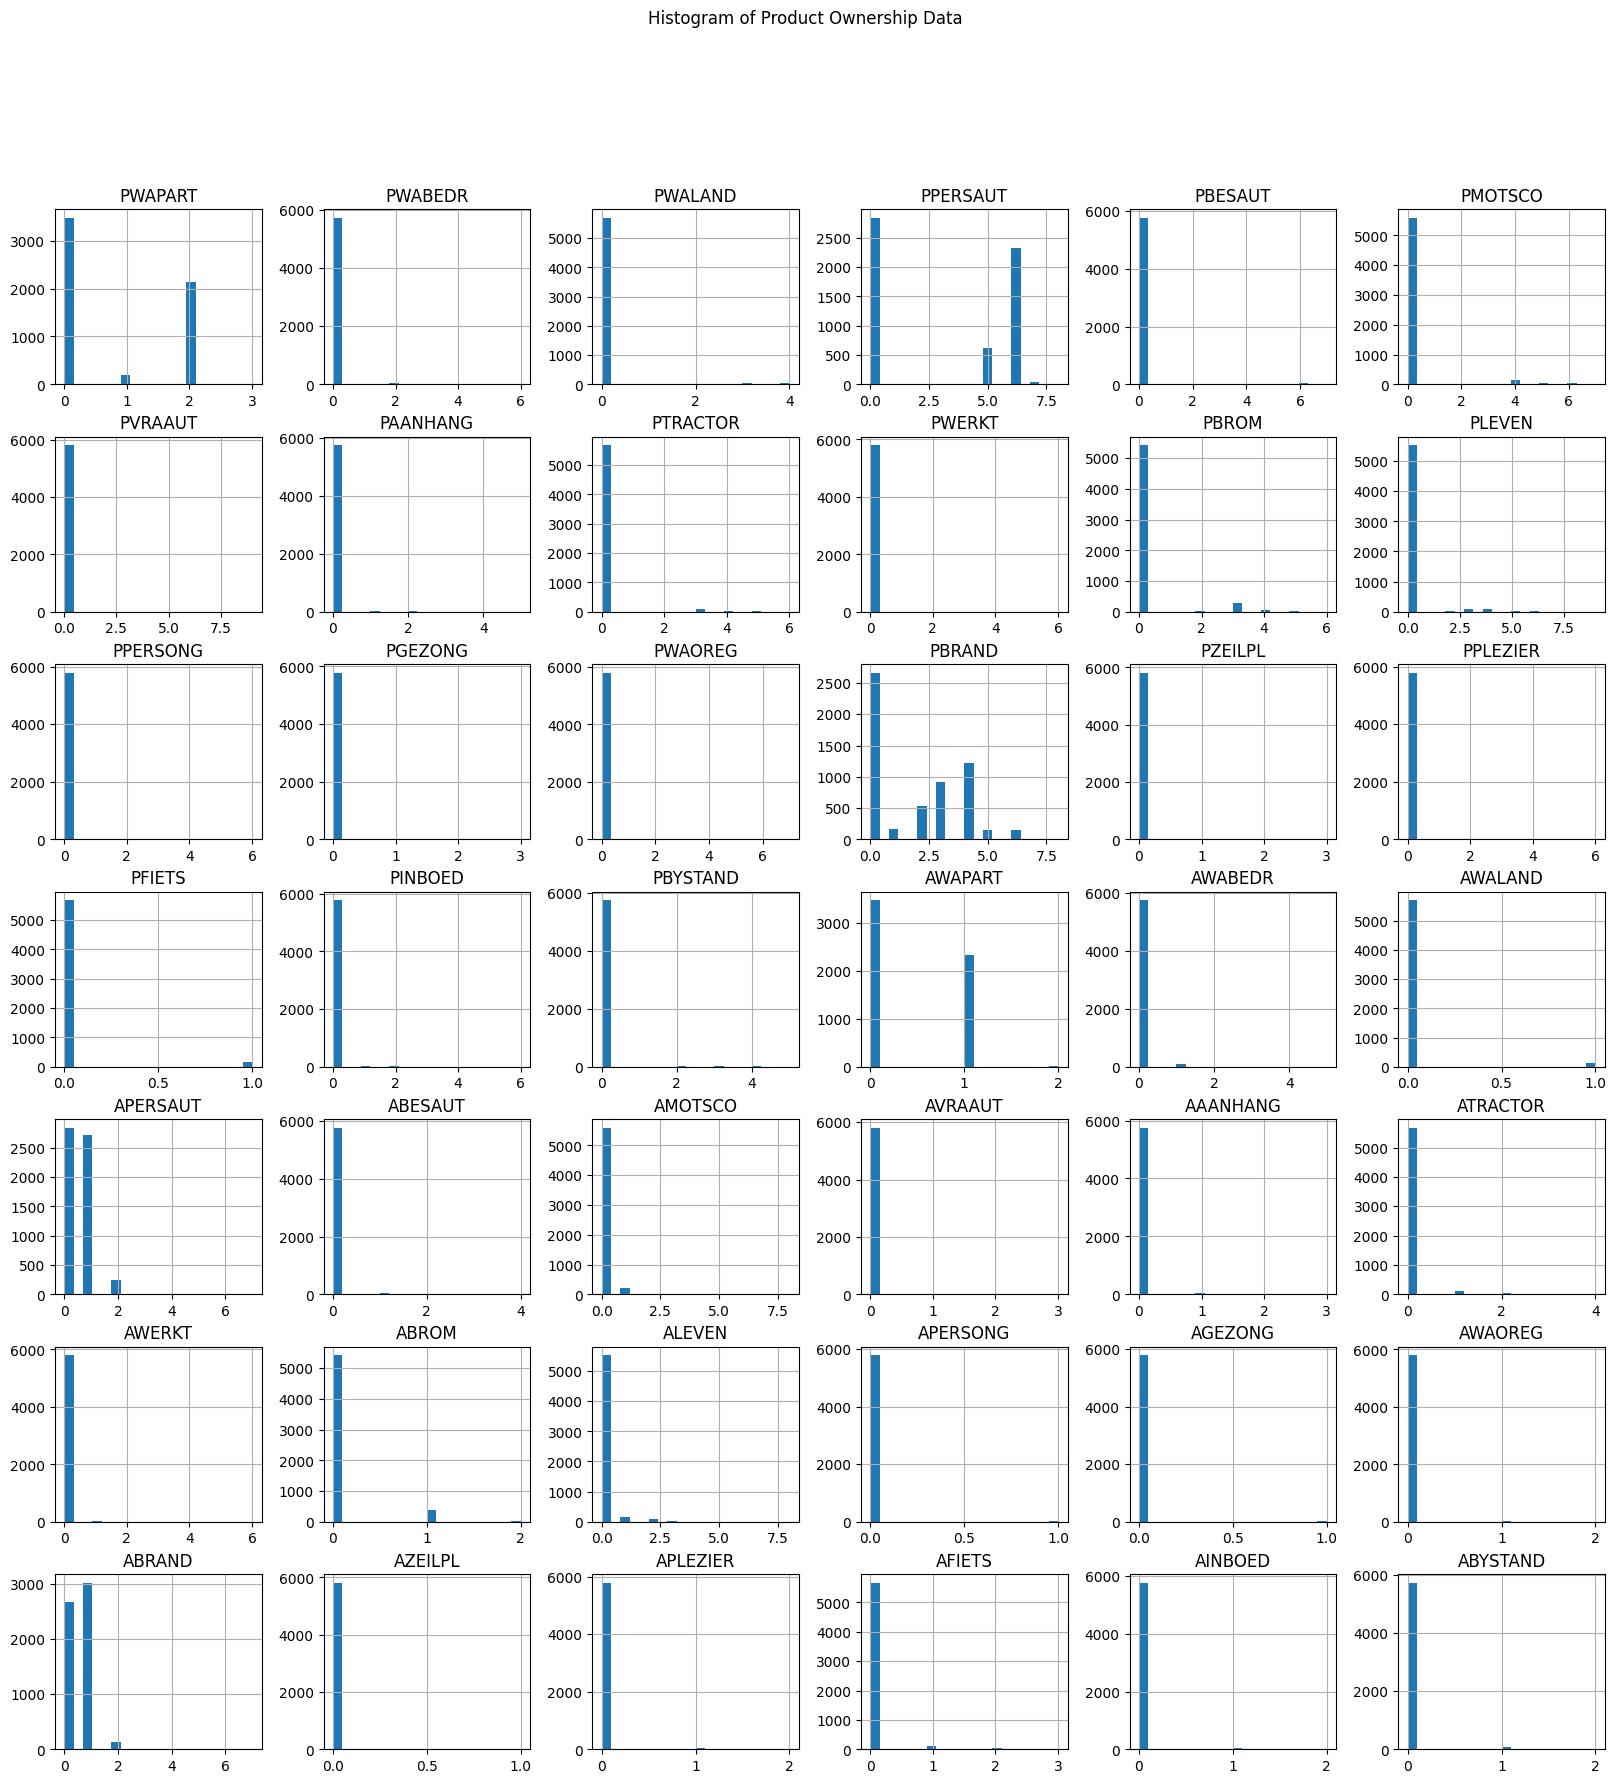

In [81]:
# product ownership data
product_ownership_data = features.iloc[:, 43:86]
# plot the histogram of the product ownership data
product_ownership_data.hist(figsize=(20, 20), bins=20)
plt.suptitle("Histogram of Product Ownership Data")
plt.show()

These are some of the key observations from Product Ownership features:

- Car policies `(PPERSAUT)` and fire insurance `(PBRAND)` are the most common. These types likely reflect the primary concerns of the population.
  
- Specialized insurance types (e.g., surfboard, boat, bicycle) and agricultural-related policies have very low adoption. This suggests that these are niche products with limited relevance to the dataset's population.
  
- Generally, most customers contribute minimally to insurance policies, indicating limited insurance coverage overall.

### Feature Correlation Analysis

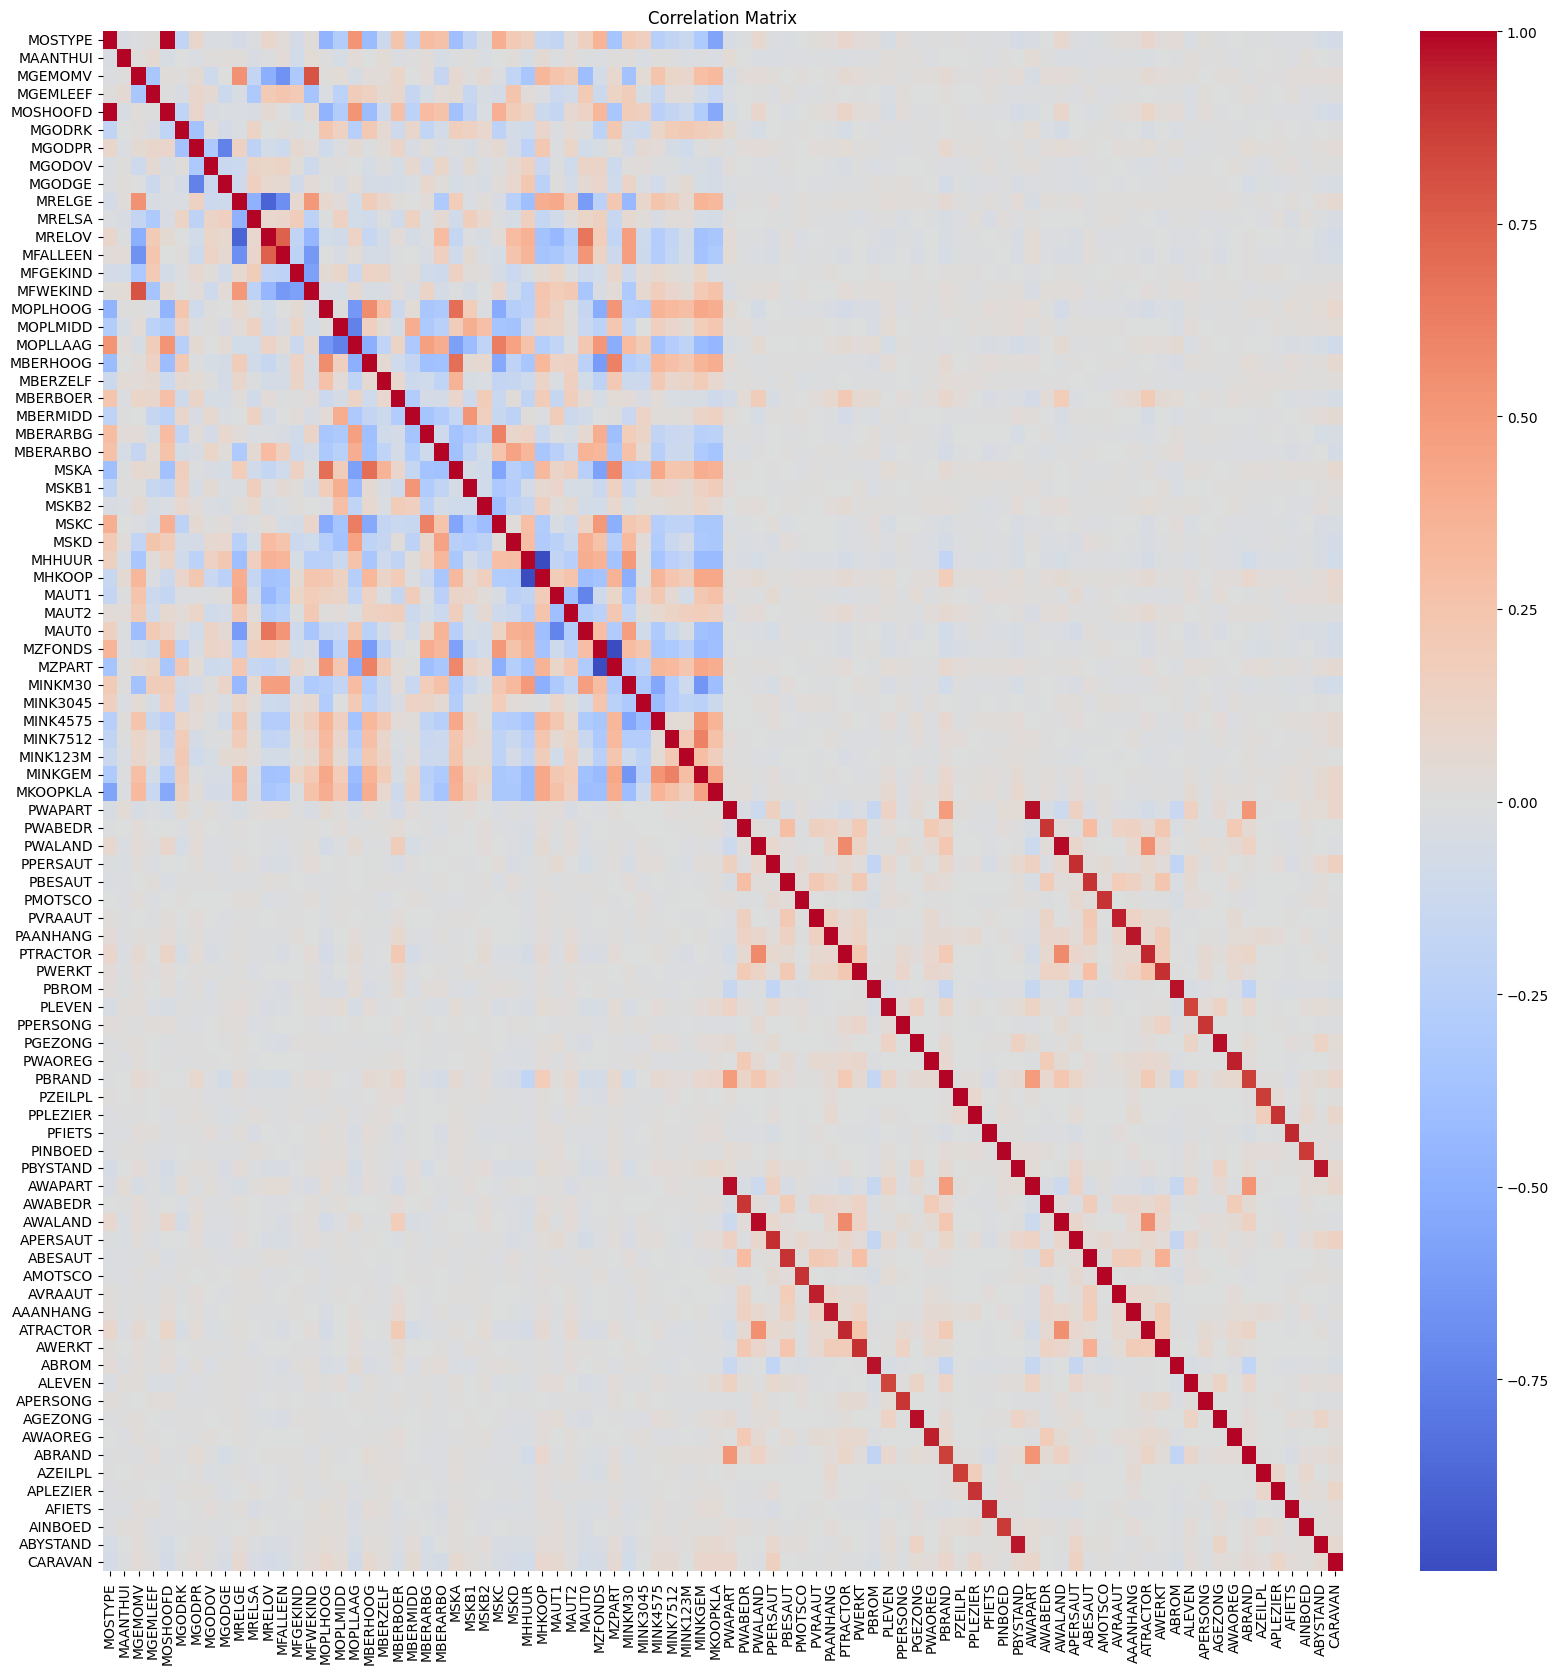

In [83]:
# compute the correlation matrix
correlation_matrix = tic_data.corr()

# plot the heatmap of the correlation matrix
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [84]:
# find the correlation between the target variable and the features
target_correlation = tic_data.corr()['CARAVAN'].sort_values(ascending=False)
target_correlation

CARAVAN     1.000000
PPERSAUT    0.150910
APERSAUT    0.144210
APLEZIER    0.105700
PWAPART     0.096463
              ...   
MOSTYPE    -0.069385
MAUT0      -0.076501
MHHUUR     -0.079143
MINKM30    -0.079765
MOPLLAAG   -0.090561
Name: CARAVAN, Length: 86, dtype: float64

Here are some of the ket observations from correlation analysis:

- Some features show strong positive or negative correlations (dark red or dark blue areas). For example: Income-related features (MINKM30, MINK3045, etc.) are highly correlated with each other. Car-related features (MAUT1, MAUT2, MAUT0) show strong correlations, as they represent mutually exclusive categories.
  
- Most features have weak correlations with the target variable (CARAVAN), as indicated by the lighter colors in the last row/column. This suggests that no single feature strongly predicts caravan insurance ownership.
  
- Features are grouped into clusters with strong internal correlations: Sociodemographic features (e.g., MOSTYPE, MOSHOOFD, MGEMLEEF) show correlations with each other. Product ownership features (e.g., PPERSAUT, PBRAND, PLEVEN) are correlated within their group.
  
- Some features are highly correlated with each other, which may lead to multicollinearity issues in predictive modeling. Education levels (MOPLHOOG, MOPLMIDD, MOPLLAAG) are negatively correlated, as they represent different education tiers. Social class features (MSKA, MSKB1, etc.) show strong correlations.

### Feature Engineering

Since the dataset has larget number of features, showing colinearily, we will remove sone of the features that are highly correlated with each other. We will also remove features that are not relevant to the prediction task.

In [87]:
# identify the features with high correlation
threshold = 0.8

high_correlation_features =  correlation_matrix[(correlation_matrix.abs() > threshold) & (correlation_matrix != 1.0)]
high_correlation_features = high_correlation_features.dropna(how='all').dropna(axis=1, how='all')
high_correlation_features = high_correlation_features[high_correlation_features != 1.0]
high_correlation_features 

,MOSTYPE,MOSHOOFD,MRELGE,MRELOV,MHHUUR,MHKOOP,MZFONDS,MZPART,PWAPART,PWABEDR,...,ALEVEN,APERSONG,AGEZONG,AWAOREG,ABRAND,AZEILPL,APLEZIER,AFIETS,AINBOED,ABYSTAND
MOSTYPE,NaN,0.992672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MOSHOOFD,0.992672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MRELGE,NaN,NaN,NaN,-0.884362,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MRELOV,NaN,NaN,-0.884362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MHHUUR,NaN,NaN,NaN,NaN,NaN,-0.999554,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MHKOOP,NaN,NaN,NaN,NaN,-0.999554,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MZFONDS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.999239,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MZPART,NaN,NaN,NaN,NaN,NaN,NaN,-0.999239,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PWAPART,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PWABEDR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:

# drop one feature from each pair of highly correlated features
features_to_drop = []

for i in range(high_correlation_features.shape[0]):
  for j in range(i + 1, high_correlation_features.shape[1]):
    if high_correlation_features.iloc[i, j] > threshold:
      features_to_drop.append(high_correlation_features.index[i])
      features_to_drop.append(high_correlation_features.columns[j])
      features_to_drop = list(set(features_to_drop))

# drop the features from the features dataframe in a new copy
features_low_correlation = features.copy()
features_low_correlation = features_low_correlation.drop(columns=features_to_drop)
features_low_correlation

,MAANTHUI,MGEMOMV,MGEMLEEF,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,...,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,MINK123M,MINKGEM,MKOOPKLA
0,1,3,2,0,5,1,3,7,0,2,...,1,8,1,0,4,5,0,0,4,3
1,1,2,2,1,4,1,4,6,2,2,...,2,6,3,2,0,5,2,0,5,4
2,1,2,2,0,4,2,4,3,2,4,...,2,9,0,4,5,0,0,0,3,4
3,1,3,3,2,3,2,4,5,2,2,...,0,7,2,1,5,3,0,0,4,4
4,1,4,2,1,4,1,4,7,1,2,...,1,5,4,0,0,9,0,0,6,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5817,1,1,2,0,6,1,2,1,2,6,...,3,5,4,4,3,3,0,0,3,3
5818,1,4,4,1,4,1,4,6,0,3,...,2,6,3,0,9,0,0,0,4,5
5819,1,3,4,0,6,0,3,5,1,4,...,5,8,1,5,3,1,1,0,3,3
5820,1,3,2,0,7,0,2,7,2,0,...,0,9,0,0,5,4,0,0,4,6


We have now removed features that are highly correlated with each other (abid 0.8) and features that might not be relevant to the prediction task. We are still left with 41 features. Hence, we will use PCA to reduce the dimensionality of the dataset. We will use 90% of the variance to determine the number of components to keep. This will help us reduce the number of features while retaining most of the information in the dataset.

In [92]:
# scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_low_correlation)


In [238]:
# apply PCA to retain 95% of the variance
pca = PCA(n_components=0.90)
features_pca = pca.fit_transform(features_scaled)

In [239]:
# get the feature contributions
pca_loadings = pd.DataFrame(pca.components_, columns=features_low_correlation.columns)
pca_loadings

,MAANTHUI,MGEMOMV,MGEMLEEF,MGODRK,MGODPR,MGODOV,MGODGE,MRELGE,MRELSA,MRELOV,...,MAUT0,MZFONDS,MZPART,MINKM30,MINK3045,MINK4575,MINK7512,MINK123M,MINKGEM,MKOOPKLA
0,-0.001596,-0.144189,0.045452,-0.080080,-0.027492,0.041123,0.048371,-0.190944,0.046009,0.194290,...,0.209665,0.236045,-0.236421,0.222407,0.057196,-0.196465,-0.143570,-0.099819,-0.242152,-0.222355
1,-0.010309,-0.293175,0.121473,0.131476,-0.103211,0.070651,0.027446,-0.286482,0.112801,0.276773,...,0.203109,-0.162995,0.162462,0.124750,-0.167706,0.005393,0.054550,0.085246,0.001128,-0.012772
2,-0.036085,0.032881,-0.297512,0.074228,-0.186919,0.101668,0.133318,-0.059004,0.254903,-0.050944,...,-0.079427,0.152200,-0.150918,-0.075628,0.145174,-0.013311,-0.041625,-0.059184,0.004735,0.057300
3,0.035449,0.189522,-0.170253,0.191858,-0.462928,0.041908,0.414392,-0.022825,0.061701,0.015095,...,0.051824,-0.010220,0.006468,0.043820,-0.215204,0.059086,0.154991,0.182822,0.103554,0.065816
4,0.015805,0.205060,-0.181179,0.062005,0.120086,-0.083178,-0.100805,-0.143681,0.053101,0.153930,...,0.192730,0.007162,-0.009401,0.034155,-0.003923,-0.054837,0.002674,0.084148,-0.031928,0.014465
5,0.093836,0.106401,0.102827,-0.076217,0.162639,-0.017340,-0.152347,0.068652,-0.432926,0.129345,...,0.005800,-0.094724,0.095111,0.085491,-0.054143,0.010331,-0.113994,-0.144723,-0.111515,0.097052
6,0.024979,0.014971,-0.281429,-0.151125,0.282091,-0.146057,-0.165030,-0.152521,0.109821,0.112703,...,0.070569,0.063910,-0.065853,0.087641,-0.300030,0.269350,-0.104797,-0.050639,-0.010117,0.058457
7,-0.016723,-0.035545,0.081038,0.182784,0.140402,0.246065,-0.366091,-0.046639,0.057403,0.028273,...,0.160899,0.086139,-0.087370,-0.221420,-0.043849,0.060045,0.356924,0.178222,0.313781,0.052103
8,0.086334,-0.083186,0.120240,0.087239,0.061651,-0.347794,0.070438,0.114264,-0.093847,-0.083849,...,-0.009408,-0.191517,0.192990,0.168812,0.131701,-0.428342,0.149198,0.248061,-0.082190,0.031119
9,0.256481,-0.090343,0.114256,0.086701,-0.163138,-0.090049,0.179954,-0.130088,-0.007390,0.162466,...,0.025599,0.107690,-0.110111,-0.023518,-0.051017,0.006431,0.119276,0.036925,0.081189,0.071984


Explained Variance Ratio:  [0.21523822 0.11006862 0.06982384 0.05389598 0.0465965  0.03843544
 0.03494333 0.0338666  0.03129635 0.02987463 0.0282657  0.02676925
 0.02430223 0.02289735 0.02187843 0.02148632 0.02002904 0.01937647
 0.01830828 0.01669817 0.01610368]


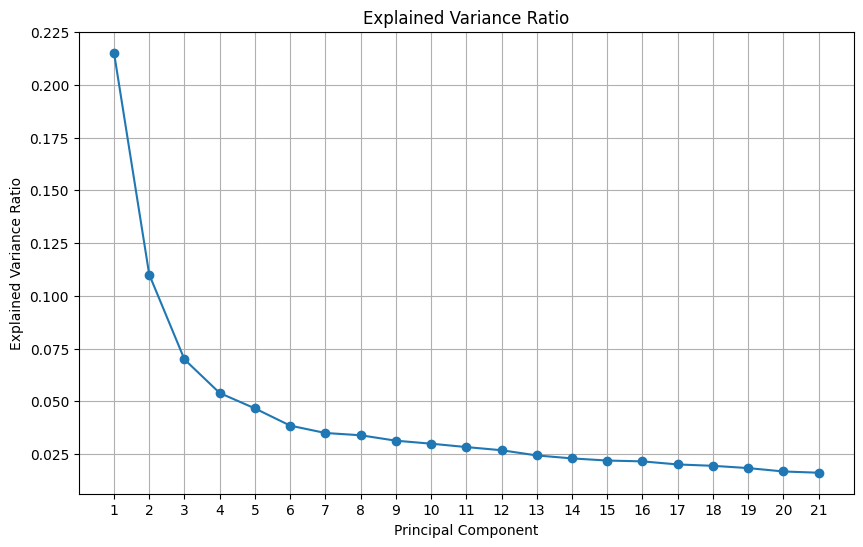

In [240]:
# get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio: ", explained_variance_ratio)

# plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title("Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.grid()
plt.show()

Here are some of the key observations from explained variance plot above

- The first principal component (PC1) explains the largest proportion of variance (~22.5%). The second principal component (PC2) explains ~10% of the variance. Together, the first few components explain a significant portion of the total variance.

- After the first few components, the explained variance decreases sharply. Subsequent components contribute progressively less variance, indicating diminishing returns.

- The "elbow" in the plot suggests the point where adding more components provides minimal additional variance. In this case, the elbow appears around 4–6 components, meaning these components capture most of the variance.

- You can choose the number of components to retain based on the cumulative explained variance (e.g., retaining components that explain 90% of the variance).

Cumulative Explained Variance Ratio:  [0.21523822 0.32530684 0.39513068 0.44902666 0.49562316 0.5340586
 0.56900192 0.60286853 0.63416488 0.66403951 0.69230521 0.71907446
 0.74337669 0.76627404 0.78815246 0.80963878 0.82966782 0.84904428
 0.86735256 0.88405073 0.90015442]


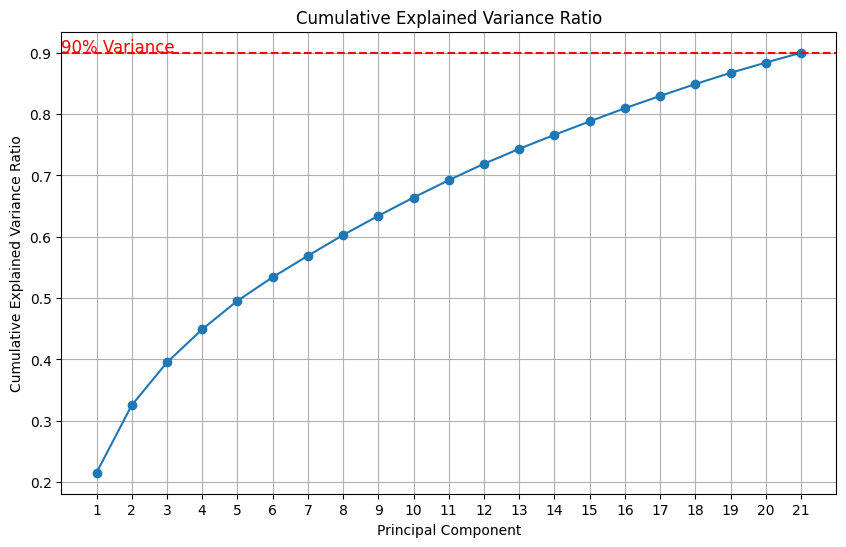

In [241]:
# get the cumulative explained variance ratio
cumulative_explained_variance_ratio = np.cumsum(explained_variance_ratio)
print("Cumulative Explained Variance Ratio: ", cumulative_explained_variance_ratio)

# plot the cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance_ratio) + 1), cumulative_explained_variance_ratio, marker='o')
plt.title("Cumulative Explained Variance Ratio")
plt.xlabel("Principal Component")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.xticks(range(1, len(cumulative_explained_variance_ratio) + 1))
plt.grid()
plt.axhline(y=0.90, color='r', linestyle='--')
plt.text(0, 0.90, '90% Variance', color='red', fontsize=12)
plt.show()

In [242]:
# from the plot we can see that we need 20 components to retain 90% of the variance
# for each component, find the top feature contributions
top_features = pca_loadings.abs().idxmax(axis=1)
top_features = top_features.drop_duplicates()
top_features = top_features.reset_index(drop=True)
top_features

0      MINKGEM
1     MFWEKIND
2     MBERMIDD
3       MGODPR
4        MAUT1
5       MRELSA
6        MSKB2
7       MGODGE
8     MINK4575
9       MHHUUR
10    MINK3045
11    MAANTHUI
12      MGODRK
13    MBERZELF
14    MINK123M
15    MBERBOER
16    MOPLMIDD
17    MKOOPKLA
dtype: object

We see that 20 components are needed to explain 90% of the variance in the dataset. These compoenents have 17 unique features each of which explains the most variance in each component. We will next use a random forrest classifier to to find important features that will be used to predict the target variable

In [243]:
features_selected = features_low_correlation[top_features]

# handle the imbalanced data in the target variable seen before
# we can use SMOTE to oversample the minority class 
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
features_train_resampled, target_train_resampled = smote.fit_resample(features_selected, target)
features_train_resampled.shape, target_train_resampled.shape


((10948, 18), (10948,))

In [244]:
# now use random forest classifier to select the important features
rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(features_train_resampled, target_train_resampled)

RandomForestClassifier(n_estimators=1000, random_state=42)

In [245]:
feature_importances = rf.feature_importances_
feature_importances = pd.Series(feature_importances, index=features_selected.columns)
feature_importances = feature_importances.sort_values(ascending=False)
print("Feature Importances: ")
print(feature_importances)

Feature Importances: 
MHHUUR      0.096059
MGODGE      0.075480
MKOOPKLA    0.074997
MGODPR      0.068645
MFWEKIND    0.067383
MINK3045    0.067272
MAUT1       0.063407
MINK4575    0.060562
MSKB2       0.060171
MOPLMIDD    0.057796
MBERBOER    0.052909
MBERMIDD    0.052900
MGODRK      0.049996
MINKGEM     0.049818
MRELSA      0.046446
MBERZELF    0.023301
MINK123M    0.018432
MAANTHUI    0.014426
dtype: float64


In [246]:
selector = SelectFromModel(rf, prefit=True) # mean by default
selected_features = selector.transform(features_train_resampled) 

# find the selected features
selected_features = pd.DataFrame(selected_features, columns=features_selected.columns[selector.get_support()])
selected_features

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


,MFWEKIND,MGODPR,MAUT1,MSKB2,MGODGE,MINK4575,MHHUUR,MINK3045,MOPLMIDD,MKOOPKLA
0,6,5,8,2,3,5,1,4,2,3
1,5,4,7,3,4,5,2,0,5,4
2,2,4,7,0,4,0,7,5,5,4
3,4,3,9,1,4,3,5,5,4,4
4,4,4,6,0,4,9,4,0,4,3
...,...,...,...,...,...,...,...,...,...,...
10943,6,4,6,1,4,2,4,4,2,3
10944,5,4,8,3,4,3,7,3,5,4
10945,6,4,7,5,3,4,7,5,7,6
10946,3,1,6,0,5,0,9,2,1,3


Hence, we are now left with 10 features on which we will build our predictive model. These features are:
- MFWEKIND: Household with children
  
- MGODPR: Protestant
  
- MAUT1: 1 car
  
- MSKB2: Social Class B2
  
- MGODGE: No religion
  
- MINK4575: Income 45-75k
  
- MHHUUR: Rented House
  
- MINK3045: Income 30-45k
  
- MOPLMIDD: Medium Education
  
- MKOOPKLA: Purchasing Power Class

### Modeling and Evaluation

In [247]:
# choose the selected features
features_train_resampled = selected_features.copy()

features_train_resampled.shape, target_train_resampled.shape

((10948, 10), (10948,))

In [248]:
# load the test data
features_test = pd.read_csv('ticeval2000.txt', sep='\t', header=None)

# map the columns to the dictionary
features_test.columns = [i for i in range(1, features_test.shape[1] + 1)]
features_test = features_test.rename(columns=column_mapping_dict)

# select the features from the test data applied in the training data
features_test = features_test[selected_features.columns]



In [249]:
# load the test target data
target_test = pd.read_csv('tictgts2000.txt', sep='\t', header=None)
target_test.columns = ['CARAVAN']
target_test

,CARAVAN
0,0
1,1
2,0
3,0
4,0
...,...
3995,0
3996,1
3997,0
3998,0


#### Predictive Modeling

We will test among 3 different models to predict the target variable. These models are:
- Random Forest Classifier: A tree-based ensemble model that combines multiple decision trees to improve accuracy and reduce overfitting.
  
- Gradient Boosting Classifier (XGBoost and LightGBM): 
  - XGBoost: An optimized gradient boosting algorithm that uses decision trees and regularization to improve performance.
  - LightGBM: A gradient boosting framework that uses tree-based learning algorithms, designed for distributed and efficient training.
  
- Logistic Regression: A linear model that estimates the probability of a binary outcome based on input features.

In [250]:
# define the hyperparameters grid for the models

rf_params = {
    'n_estimators': [100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 5],
}

xgb_params = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2, 1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

lr_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga', 'lbfgs'],
}

#### Random Forest Classifier

In [163]:
rf = RandomForestClassifier(random_state=42)

rf_grid = GridSearchCV(estimator=rf, param_grid=rf_params, cv=5, n_jobs=-1, verbose=3)
rf_grid.fit(features_train_resampled, target_train_resampled)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.844 total time=   2.2s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.945 total time=   2.2s
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.943 total time=   2.2s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.941 total time=   2.2s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.941 total time=   2.3s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.844 total time=   4.6s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.943 total time=   4.6s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.943 total time=   4.7s
[CV 4/5] END max_depth=None, min_samples

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30, 50],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 500, 1000]},
             verbose=3)

In [164]:
print("Best Parameters for Random Forest: ", rf_grid.best_params_)
print("Best Score for Random Forest: ", rf_grid.best_score_)

# save the best model
import pickle
with open('best_rf_model.pkl', 'wb') as f:
    pickle.dump(rf_grid.best_estimator_, f)

Best Parameters for Random Forest:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best Score for Random Forest:  0.9238251030995576


#### XGBoost Classifier

In [251]:
xgb = XGBClassifier(random_state=42)

xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=5, n_jobs=-1, verbose=3)
xgb_grid.fit(features_train_resampled, target_train_resampled)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, n_estimators=100, subsample=0.8;, score=0.761 total time=   0.4s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, n_estimators=100, subsample=0.8;, score=0.805 total time=   0.3s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, n_estimators=100, subsample=0.8;, score=0.809 total time=   0.4s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.01, n_estimators=100, subsample=0.8;, score=0.820 total time=   0.4s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.01, n_estimators=100, subsample=1.0;, score=0.762 total time=   0.4s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.01, n_estimators=100, subsample=0.8;, score=0.793 total time=   0.4s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.01, n_estimators=100, subsample=1.0;, score=0.803 total time=   0.4s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.01, n_estimators=100, subsample=1.0;, score=0.8

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=Non...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2, 1],
                         'n_estimators': [100, 200, 500, 1000],
                         'subsample': [0.8, 1.0]},
             verbose=3)

In [252]:
print("Best parameters for XGBoost: ", xgb_grid.best_params_)
print("Best score for XGBoost: ", xgb_grid.best_score_)

# save the best model
with open('best_xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_grid.best_estimator_, f)

Best parameters for XGBoost:  {'colsample_bytree': 0.8, 'learning_rate': 1, 'n_estimators': 1000, 'subsample': 1.0}
Best score for XGBoost:  0.9250126097486187


#### Logistic Regression

In [173]:
lr = LogisticRegression(max_iter=1000, random_state=42)

lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params, cv=5, n_jobs=-1, verbose=3)
lr_grid.fit(features_train_resampled, target_train_resampled)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.605 total time=   0.1s
[CV 2/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.613 total time=   0.1s
[CV 3/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.595 total time=   0.2s
[CV 4/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.608 total time=   0.2s
[CV 1/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.01, penalty=l1, solver=liblinear;, score=0.600 total time=   0.2s
[CV 3/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END ....C=0.01, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.01, penalty=l2, solver=liblinear;, score=0.607 total time=   0.1s
[CV 4/5] END C=0.01, penalty=l2, so

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File 

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'penalty': ['l1', 'l2', 'elasticnet'],
                         'solver': ['liblinear', 'saga', 'lbfgs']},
             verbose=3)

In [174]:
print(f"Best parameters for Logistic Regression: ", lr_grid.best_params_)
print(f"Best score for Logistic Regression: ", lr_grid.best_score_)

# save the best model
with open('best_lr_model.pkl', 'wb') as f:
    pickle.dump(lr_grid.best_estimator_, f)

Best parameters for Logistic Regression:  {'C': 1, 'penalty': 'l2', 'solver': 'saga'}
Best score for Logistic Regression:  0.6670634200475186


With hyperparameter tuning complete, we have the best estimators for each model. We will now evaluate the performance of each model using the test set

In [254]:
# load the best models first to avoid re-training in future
with open('best_rf_model.pkl', 'rb') as f:
    best_rf_model = pickle.load(f)
    
with open('best_xgb_model.pkl', 'rb') as f:
    best_xgb_model = pickle.load(f)
    
with open('best_lr_model.pkl', 'rb') as f:
    best_lr_model = pickle.load(f)

#### Logistic Regression Model Evaluation

In [178]:
# logistic regression model
train_accuracy = accuracy_score(target_train_resampled, best_lr_model.predict(features_train_resampled))
test_accuracy = accuracy_score(target_test, best_lr_model.predict(features_test))

print(f"Logistic Regression Train Accuracy: {train_accuracy}")
print(f"Logistic Regression Test Accuracy: {test_accuracy}")

Logistic Regression Train Accuracy: 0.6663317500913409
Logistic Regression Test Accuracy: 0.66575


In [179]:
lr_test_roc_auc = roc_auc_score(target_test, best_lr_model.predict_proba(features_test)[:, 1])
print(f"Logistic Regression Test ROC AUC: {lr_test_roc_auc}")

Logistic Regression Test ROC AUC: 0.5796772456989175


In [180]:
lr_cr_tet = classification_report(target_test, best_lr_model.predict(features_test))
print("Logistic Regression Classification Report: ")
print(lr_cr_tet)

Logistic Regression Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.68      0.79      3762
           1       0.08      0.42      0.13       238

    accuracy                           0.67      4000
   macro avg       0.51      0.55      0.46      4000
weighted avg       0.90      0.67      0.75      4000



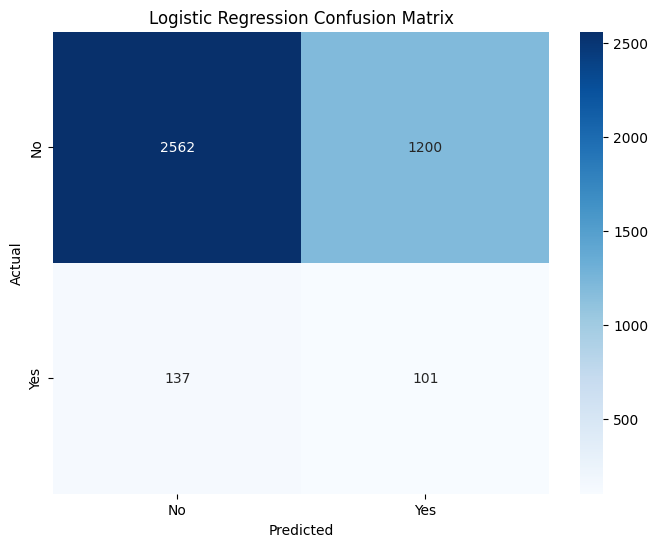

In [182]:
# confusion matrix
lr_cm_test = confusion_matrix(target_test, best_lr_model.predict(features_test))

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.show()

From the evaluation metric, we observe that logistic regression has a low test accuracy of 66.75%. On observing the confusion matrix, we see that the model is predicting most of the customers who have not taken out a caravan insurance policy correctly but struggles with the customers who have taken out a caravan insurance policy.

### XGB Classifier Model Evaluation

In [255]:
xgb_train_accuracy = accuracy_score(target_train_resampled, best_xgb_model.predict(features_train_resampled))
xgb_test_accuracy = accuracy_score(target_test, best_xgb_model.predict(features_test))

print(f"XGBoost Train Accuracy: {xgb_train_accuracy}")
print(f"XGBoost Test Accuracy: {xgb_test_accuracy}")


XGBoost Train Accuracy: 0.9510412860796492
XGBoost Test Accuracy: 0.8795


In [256]:
xgb_roc_auc = roc_auc_score(target_test, best_xgb_model.predict_proba(features_test)[:, 1])
print(f"XGBoost Test ROC AUC: {xgb_roc_auc}")

XGBoost Test ROC AUC: 0.5830245176220409


In [257]:
xgb_cr_test = classification_report(target_test, best_xgb_model.predict(features_test))
print("XGBoost Classification Report: ")
print(xgb_cr_test)

XGBoost Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      3762
           1       0.11      0.15      0.13       238

    accuracy                           0.88      4000
   macro avg       0.53      0.54      0.53      4000
weighted avg       0.90      0.88      0.89      4000



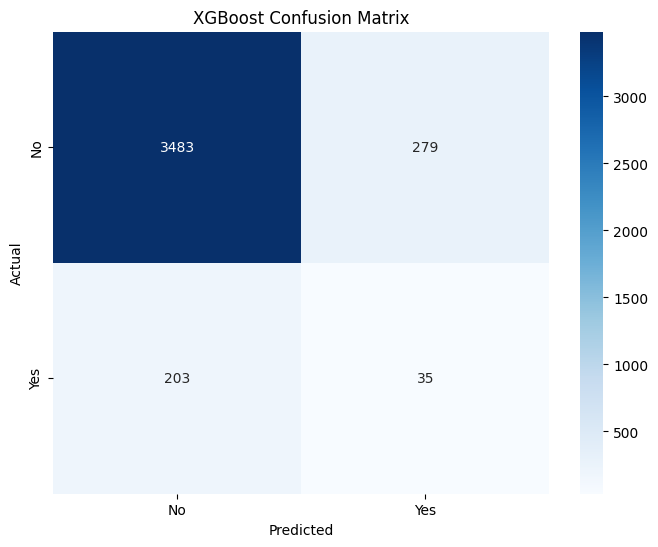

In [258]:
xgb_cm_test = confusion_matrix(target_test, best_xgb_model.predict(features_test))

# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(xgb_cm_test, annot=True, fmt='d', cmap='Blues')
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.show()

The XGBoost classifier performs well on the majority class but struggles significantly with the minority class.
The low precision, recall, and F1-score for the "Yes" class indicate poor performance in identifying customers who have taken out a caravan insurance policy

#### Random Forest Classifier Model Evaluation

In [259]:
train_accuracy_rf = accuracy_score(target_train_resampled, best_rf_model.predict(features_train_resampled))
test_accuracy_rf = accuracy_score(target_test, best_rf_model.predict(features_test))

print(f"Random Forest Train Accuracy: {train_accuracy_rf}")
print(f"Random Forest Test Accuracy: {test_accuracy_rf}")

Random Forest Train Accuracy: 0.9510412860796492
Random Forest Test Accuracy: 0.88475


In [260]:
# roc_auc
rf_test_roc_auc = roc_auc_score(target_test, best_rf_model.predict_proba(features_test)[:, 1])
print(f"Random Forest Test ROC AUC: {rf_test_roc_auc}")

Random Forest Test ROC AUC: 0.5821232001572558


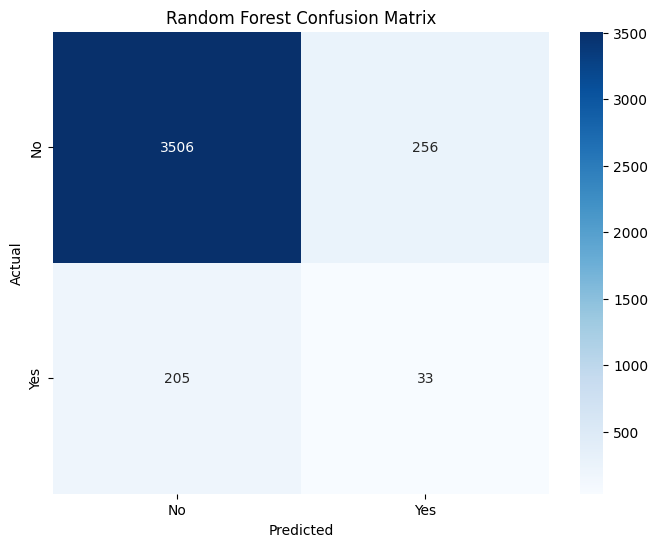

In [261]:
# confusion matrix
confusion_matrix_rf = confusion_matrix(target_test, best_rf_model.predict(features_test))
# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_rf, annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.yticks(ticks=[0.5, 1.5], labels=['No', 'Yes'])
plt.show()

In [264]:
# we observe that random forest has the best accuracy amongst the selected three models

predict_proba_rf = best_rf_model.predict_proba(features_test)[:, 1]

# rank the customers in the test set based on the probability of being a caravan customer
ranked_customers = pd.DataFrame({'Customer ID': features_test.index, 'Probability': predict_proba_rf})
ranked_customers = ranked_customers.sort_values(by='Probability', ascending=False)

# select the top 800 customers
top_800_customers = ranked_customers.head(800)
top_800_customers

,Customer ID,Probability
2759,2759,0.998000
2621,2621,0.998000
2416,2416,0.994000
3896,3896,0.994000
2112,2112,0.994000
...,...,...
2823,2823,0.221564
966,966,0.221564
1455,1455,0.221564
1746,1746,0.219744


### Descriptive Task

We will now perform a descriptive task to understand why customers have a caravan insurance policy and how they differ from ohers

In [265]:
# lets first see the dataset that we had after resampling
features_train_resampled

,MFWEKIND,MGODPR,MAUT1,MSKB2,MGODGE,MINK4575,MHHUUR,MINK3045,MOPLMIDD,MKOOPKLA
0,6,5,8,2,3,5,1,4,2,3
1,5,4,7,3,4,5,2,0,5,4
2,2,4,7,0,4,0,7,5,5,4
3,4,3,9,1,4,3,5,5,4,4
4,4,4,6,0,4,9,4,0,4,3
...,...,...,...,...,...,...,...,...,...,...
10943,6,4,6,1,4,2,4,4,2,3
10944,5,4,8,3,4,3,7,3,5,4
10945,6,4,7,5,3,4,7,5,7,6
10946,3,1,6,0,5,0,9,2,1,3


In [266]:
target_train_resampled

0        0
1        0
2        0
3        0
4        0
        ..
10943    1
10944    1
10945    1
10946    1
10947    1
Name: CARAVAN, Length: 10948, dtype: int64

In [267]:
# we will look into finding the feature importances 
# we will use a random forest classifier to find the feature importances

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(features_train_resampled, target_train_resampled)


RandomForestClassifier(n_estimators=1000, random_state=42)

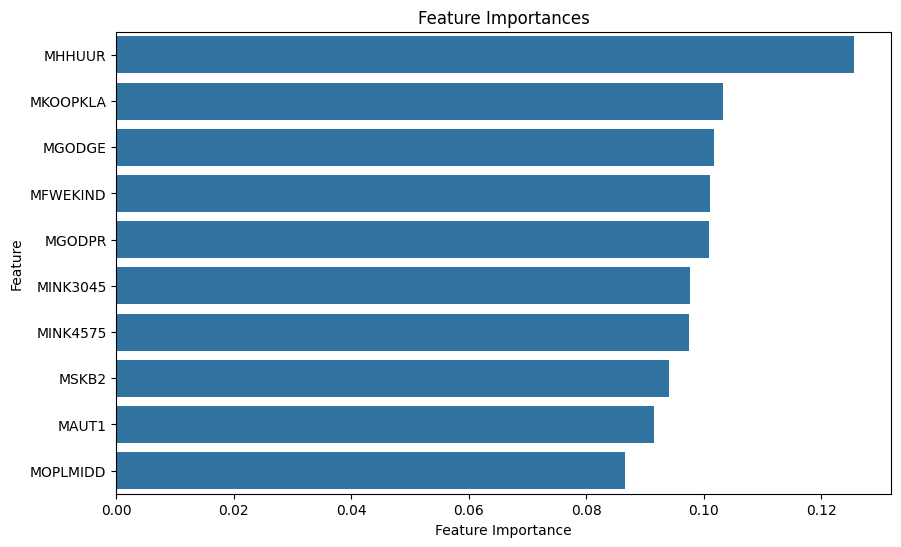

In [268]:
feature_importances = pd.Series(rf.feature_importances_, index=features_train_resampled.columns)
feature_importances = feature_importances.sort_values(ascending=False)

# plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title("Feature Importances")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

Here are some of the key observations from the getting feature importance

- The most important feature is MHHUUR (Rented House), indicating that whether a customer rents a house is the strongest predictor for caravan insurance ownership.
  
- Many of the top features are socio-demographic, such as income levels (MINK3045, MINK4575), education level (MOPLMIDD), and social class (MSKB2). This suggests that socio-economic factors play a significant role in determining caravan insurance ownership.
  
- MAUT1 (1 Car) is the only product ownership feature in the top 10, indicating that car ownership has some influence but is less important compared to socio-demographic factors.
  
- The feature importances are relatively balanced, with no single feature dominating completely. This indicates that multiple factors collectively contribute to predicting caravan insurance ownership.

### K-Means Clustering

We will now perform K-Means clustering to identify distinct customer segments based on the selected features. This will help us understand the different groups of customers and their characteristics.

We will use the elbow method to determine the optimal number of clusters. The elbow method involves plotting the within-cluster sum of squares (WCSS) against the number of clusters and looking for an "elbow" point where adding more clusters does not significantly reduce WCSS.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.1

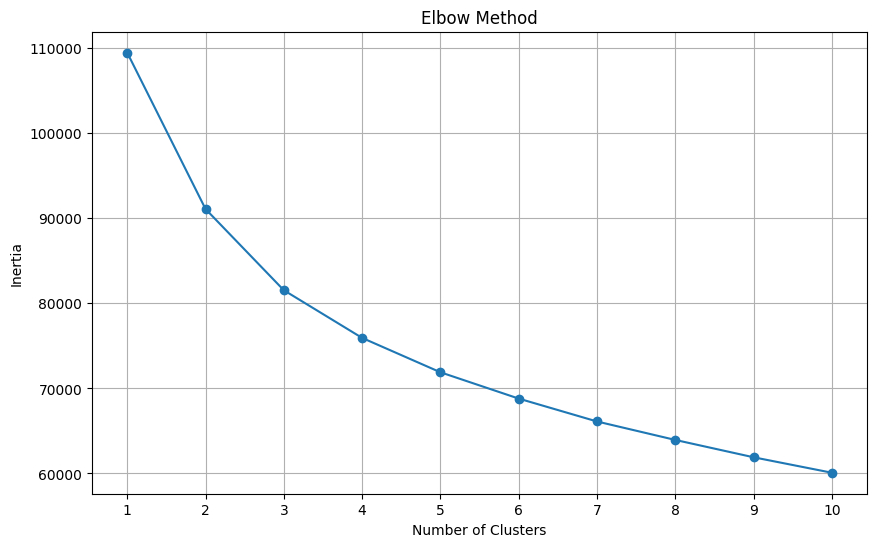

In [270]:
# kmeans clustering

# use the elbow method to find the optimal number of clusters
inertia = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    temp_scaled_features = scaler.fit_transform(features_train_resampled)
    kmeans.fit(temp_scaled_features)
    
    inertia.append(kmeans.inertia_)
    
# plot the elbow method
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.xticks(range(1, 11))
plt.grid()
plt.show()

From the Elbow Method graph, the "elbow" point is where the rate of decrease in inertia slows down significantly. In this graph, the elbow appears around 3 clusters, as the reduction in inertia becomes less steep after this point.

In [276]:
# apply kmeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)

temp_scaled_features = scaler.fit_transform(features_train_resampled)
kmeans.fit(temp_scaled_features)

# add the cluster labels to the features dataframe
features_train_resampled['Cluster'] = kmeans.labels_
features_train_resampled['Cluster'] = features_train_resampled['Cluster'].astype('category')
features_train_resampled['Cluster'].value_counts()
# plot the clusters


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster
0    4528
2    3234
1    3186
Name: count, dtype: int64

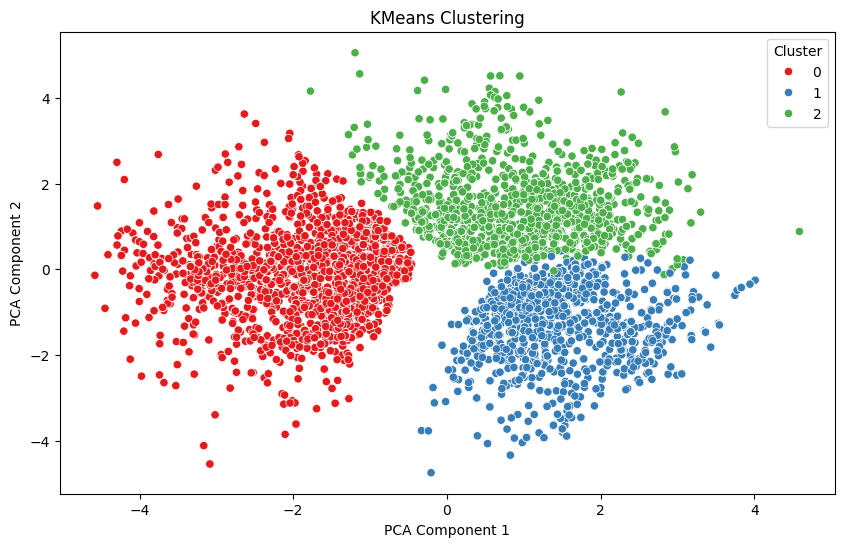

In [279]:
# visualize the clusters

pca = PCA(n_components=2)
temp_scaled_pca = pca.fit_transform(temp_scaled_features)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=temp_scaled_pca[:, 0], y=temp_scaled_pca[:, 1], hue=features_train_resampled['Cluster'], palette='Set1')

plt.title("KMeans Clustering")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title='Cluster')
plt.show()

Here are some of the key observations from cluster analysis

- The data points are grouped into three distinct clusters (Cluster 0, Cluster 1, and Cluster 2), as determined by the elbow method. Each cluster represents a group of customers with similar characteristics based on the selected features.
  
- The clusters are well-separated in the PCA space, indicating that the K-Means algorithm successfully identified meaningful differences between customer groups.

To interpret the clusters, we will now find the mean values of the features for each cluster.

In [280]:
# interpret the clusters
cluster_summary = features_train_resampled.groupby('Cluster').mean()

print("Cluster Summary: ")
print(cluster_summary)

Cluster Summary: 
         MFWEKIND    MGODPR     MAUT1     MSKB2    MGODGE  MINK4575    MHHUUR  \
Cluster                                                                         
0        3.551016  3.909894  5.650398  1.800353  3.728799  1.806758  6.048587   
1        4.494350  6.074388  6.172944  2.444758  1.742938  2.579724  1.946014   
2        5.097093  4.098021  6.736858  2.162338  3.287879  4.539579  1.945887   

         MINK3045  MOPLMIDD  MKOOPKLA  
Cluster                                
0        3.534673  2.803666  3.086572  
1        4.511299  3.622724  4.551475  
2        2.118429  3.870748  6.330241  


/var/folders/hk/nph4_yk10yqbq0nqmjx6nmgr0000gn/T/ipykernel_64616/3899896685.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_summary = features_train_resampled.groupby('Cluster').mean()


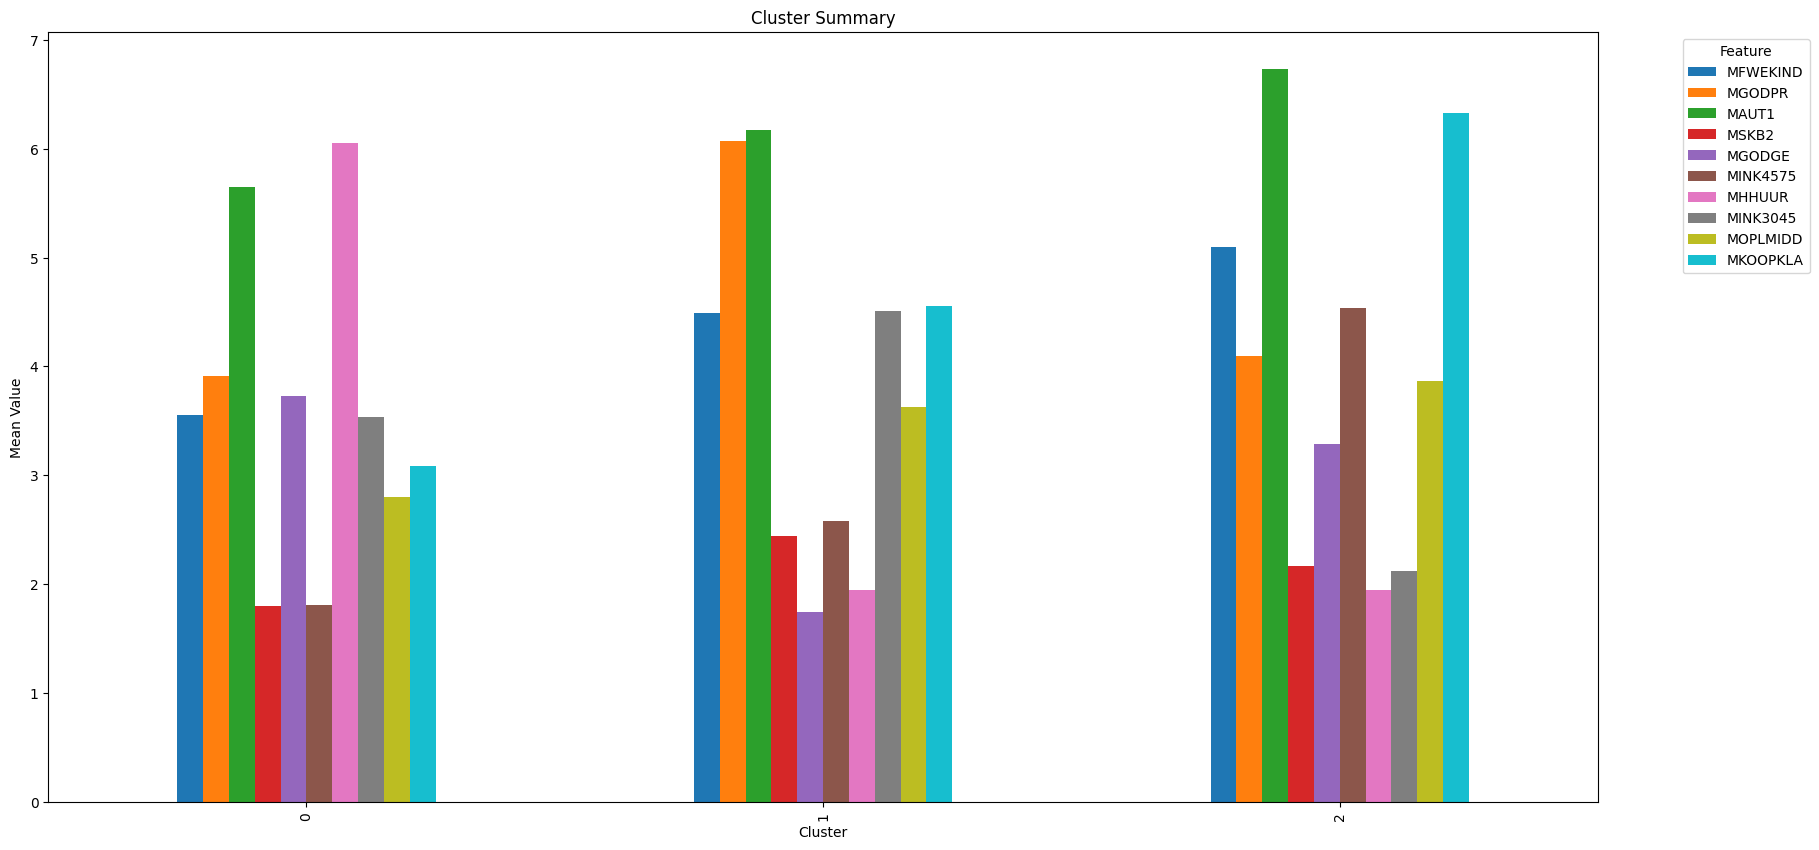

In [281]:
# visualize the cluster summary
cluster_summary.plot(kind='bar', figsize=(20, 10))

plt.title("Cluster Summary")
plt.xlabel("Cluster")
plt.ylabel("Mean Value")
plt.legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

From the bar plot, we can identify the characteristics of each cluster:

- Cluster 0: This cluster likely represents middle-income renters with a mix of family types (with and without childeren)
  
- Cluster 1: This cluster likely represents high-income homeowners with no children.
  
- Cluster 2: This cluster likely represents low-income families with children and limited purchasing power.



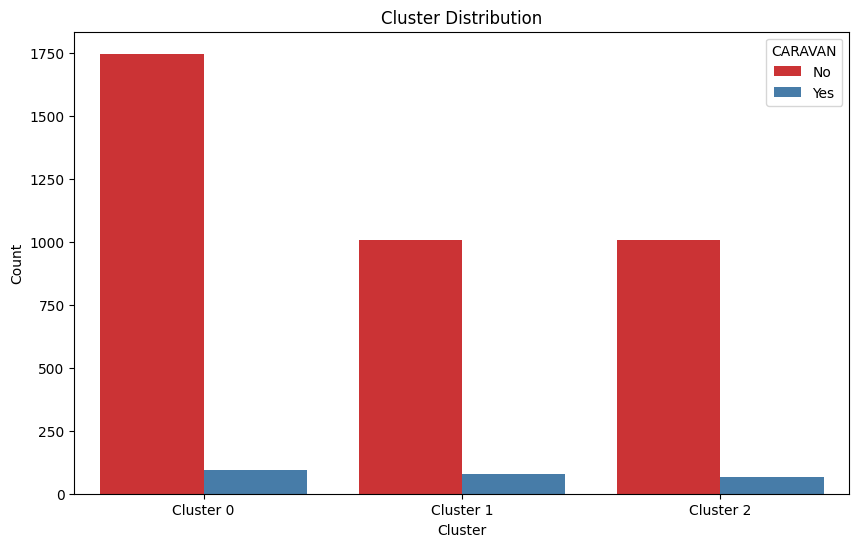

In [292]:
# using the cluster labels, lets find out which of these clusters are more likely to be caravan customers
target_train_resampled = pd.read_csv('tictgts2000.txt', sep='\t', header=None)
target_train_resampled.columns = ['CARAVAN']

target_train_resampled = pd.DataFrame(target_train_resampled)
target_train_resampled['Cluster'] = features_train_resampled['Cluster']

target_train_resampled['Cluster'] = target_train_resampled['Cluster'].astype('category')
target_train_resampled['CARAVAN'] = target_train_resampled['CARAVAN'].astype('category')
target_train_resampled['Cluster'] = target_train_resampled['Cluster'].cat.rename_categories({0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2'})
target_train_resampled['CARAVAN'] = target_train_resampled['CARAVAN'].cat.rename_categories({0: 'No', 1: 'Yes'})

# plot the cluster distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Cluster', hue='CARAVAN', data=target_train_resampled, palette='Set1')
plt.title("Cluster Distribution")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title='CARAVAN')
plt.show()

From the plot above, we observe that majority of the customers in all clusters have not taken out a caravan insurance policy. Based on that, here's how we can tailor our marketing strategy for each cluster:

- **Cluster 0 (Middle-Income Renters with or without children)**: 
  - Focus on awareness campaigns to educate this group about the benefits of caravan insurance.
  
  - Highlight affordable plans and flexible payment options to appeal to middle-income renters.
  
  - Use family-oriented messaging to target households with children.
  
- **Cluster 1 (High-Income Homeowners with no children)**: 
  - Promote premium caravan insurance plans with added benefits (e.g., travel coverage, luxury add-ons).
    
  - Highlight exclusive offers and personalized services to appeal to high-income individuals.
    
  - Use targeted advertising on platforms frequented by affluent homeowners.
  
- **Cluster 2 (Low-Income Families with children)**: 
  - Focus on low-cost, essential coverage plans to attract more customers in this group.
  
  - Offer family discounts or child-related benefits to appeal to families with children.
  
  - Partner with community organizations to reach low-income families and build trust.

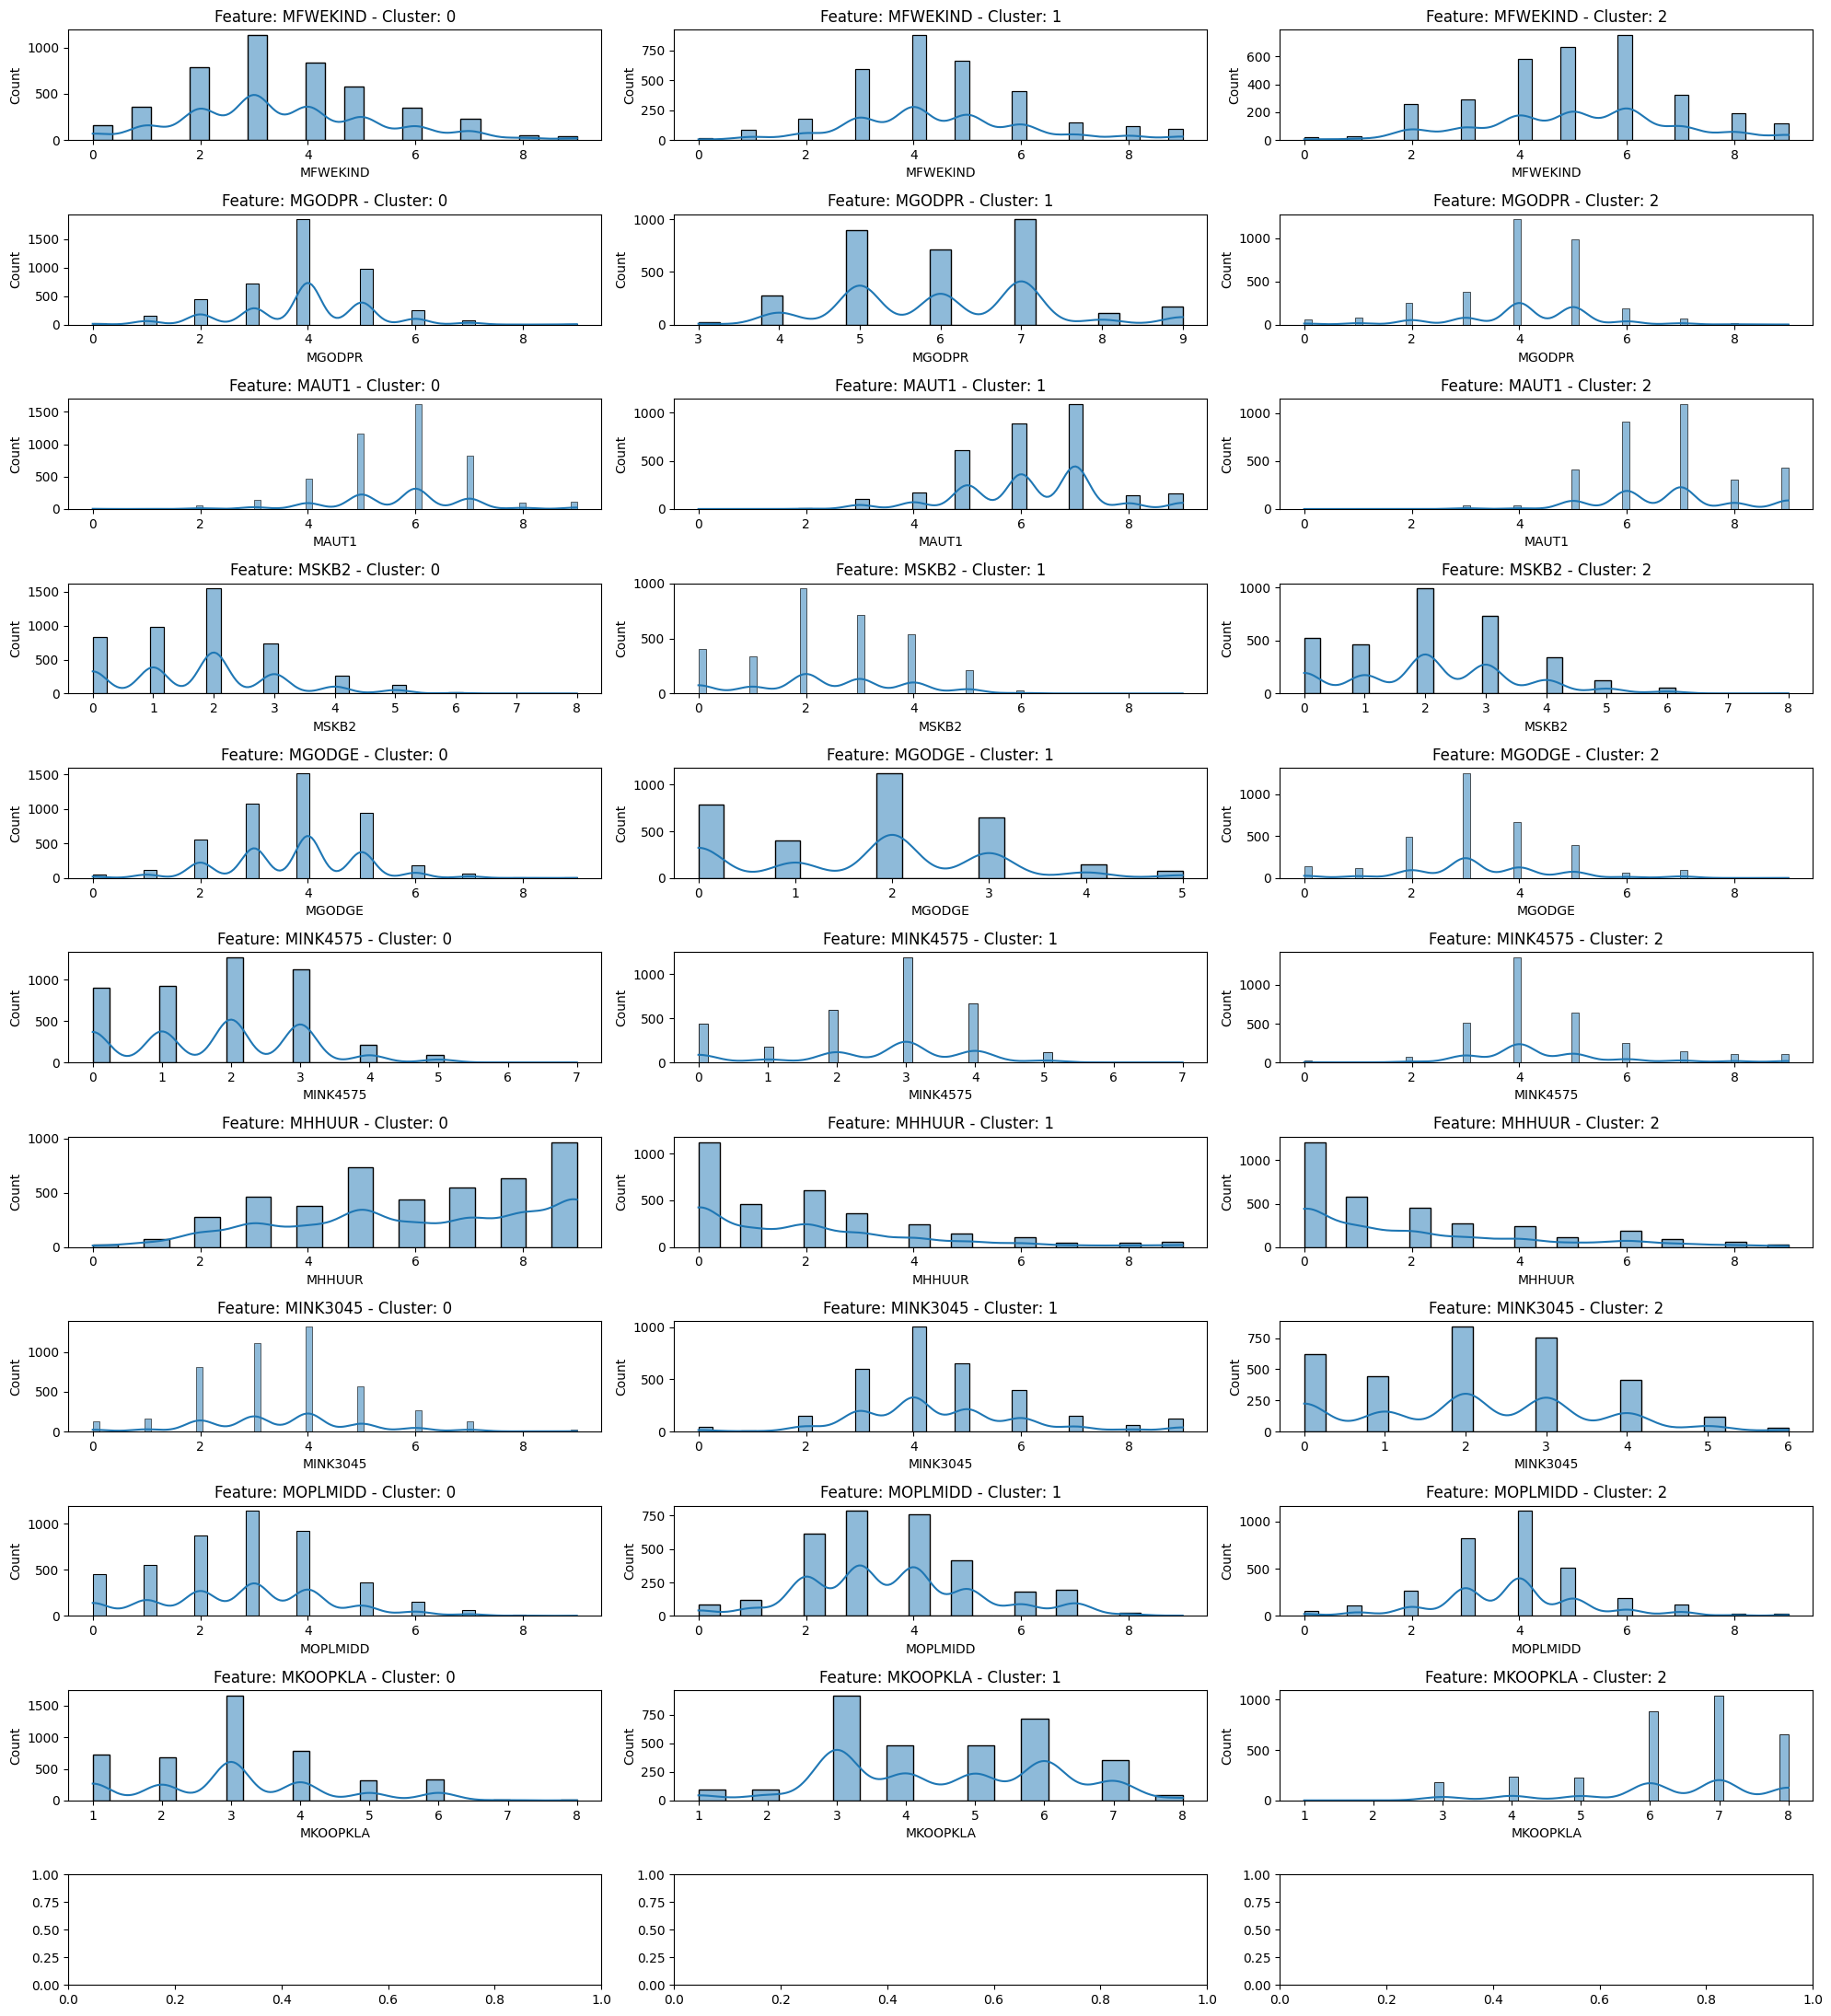

In [297]:
# we will now try to understand how individual features vary within each cluster
# plot the distribution of each feature within each cluster using suplot

def plot_feature_distribution(features, cluster_labels):
    """
    This function takes in the features and cluster labels and plots the distribution of each feature within each cluster.
    """
    num_features = features.shape[1]
    num_clusters = len(cluster_labels.unique())
    
    fig, axes = plt.subplots(num_features, num_clusters, figsize=(20, 22))
    
    for i in range(num_features - 1):  # Exclude the last column which is 'Cluster'
        for j in range(num_clusters):
            sns.histplot(data=features[features['Cluster'] == j], x=features.columns[i], ax=axes[i, j], kde=True)
            axes[i, j].set_title(f"Feature: {features.columns[i]} - Cluster: {j}")
    
    plt.tight_layout()
    plt.show()

# plot the feature distribution
plot_feature_distribution(features_train_resampled, features_train_resampled['Cluster'])

Here are some of the key observations from analyzing each feature within the clusters

- **Cluster 0**: 
  - A mix of households with and without children. Slightly higher representation of households without children
  
  - High proportion of renters compared to other clusters.
  
  - Moderate representation of middle-income groups (30-45k and 45-75k).
  
  - Higher representation of individuals with medium education.
  
  - Moderate purchasing power.
  
- **Cluster 1**:
  - Majority of households without children.
  
  - High proportion of homeowners.
  
  - Higher representation of middle-to-high income groups.
  
  - Moderate representation of individuals with medium education.
  
  - Higher purchasing power.High purchasing power compared to other clusters.

- **Cluster 2**:
  - Majority of households with children.
  
  - High proportion of renters.
  
  - Lower representation of middle-income groups (30-45k and 45-75k) indicating lower income.
  
  - Higher representation of individuals with low education.
  
  - Lower purchasing power compared to other clusters.

The silhouette score is 0.2097, indicating that the clusters are somewhat well-defined but not very distinct. A score closer to 1 would indicate better-defined clusters, while a score closer to -1 would indicate overlapping clusters. In this case, the score suggests that there is some separation between the clusters, but they are not highly distinct.